In [57]:
!pip install eli5
!pip install plotly_express --upgrade -q
!pip install tsfresh

In [90]:
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import eli5
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import progressbar # отображение прогресса работы функции
import random
import plotly_express as px # ображение графиков с наведением мышки
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # метрики классификации
import matplotlib.pyplot as plt

# Изучение сета

Загрузка **датасета HAR (Human Activity Recognition)** - база данных распознавания человеческой деятельности, построенная на основе записей 30 субъектов, выполняющих повседневную деятельность (ADL), с закрепленным на поясе смартфоном со встроенными инерционными датчиками.

In [91]:
download_har_dataset()
data = load_har_dataset()
y = load_har_classes()
data

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.388873,0.618763,0.774067,0.586568,0.217007,-0.027330,-0.171294,-0.218988,-0.137680,0.033094,...,-0.227949,-0.247119,-0.227710,-0.210942,-0.179295,-0.142085,-0.131831,-0.154000,-0.176886,-0.211068
7348,0.711864,0.709237,0.321368,-0.028921,-0.208107,-0.192802,-0.066754,-0.042285,0.058089,0.106855,...,-0.311864,-0.316281,-0.274100,-0.326159,-0.379539,-0.382544,-0.371156,-0.295357,-0.203831,-0.124548
7349,-0.226717,-0.177817,-0.150869,-0.132237,-0.068338,0.007874,0.096481,0.205834,0.441342,0.662930,...,-0.177051,-0.248426,-0.313892,-0.367070,-0.395135,-0.347338,-0.319902,-0.294935,-0.243403,-0.215215
7350,-0.064806,-0.079933,-0.068350,-0.038477,-0.028679,0.018335,0.077571,0.253580,0.507805,0.583999,...,-0.240819,-0.330930,-0.396854,-0.413906,-0.379085,-0.356609,-0.317618,-0.315016,-0.330737,-0.272348


7352 наблюдений, каждому из которых соответствуют 128 показаний акселерометра и одна из шести возможных активностей

**Отображение активности 5 человек в диапазоне 300 записей**

<Axes: title={'center': 'Accelerometer data for 5 users'}>

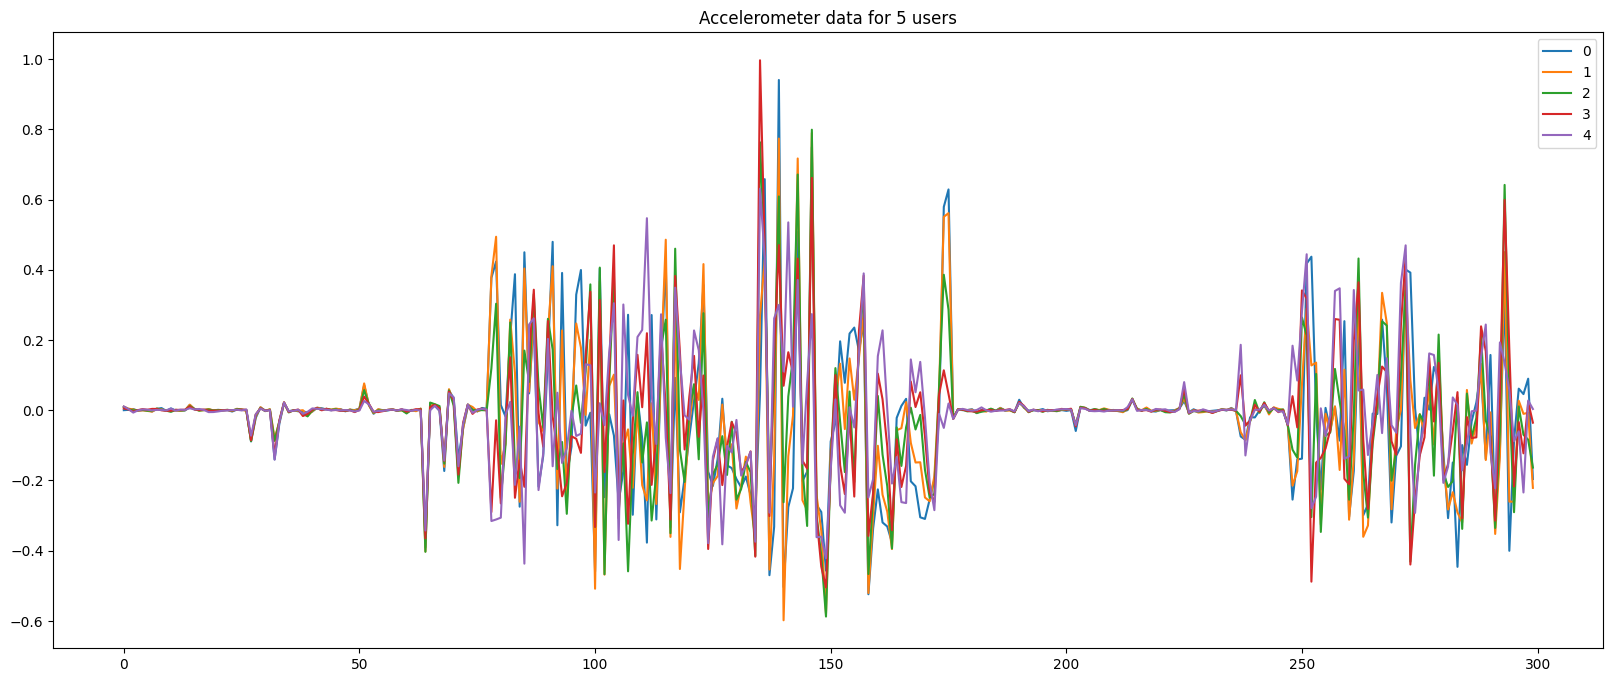

In [60]:
data.iloc[0:300:, 0:5].plot(figsize=(20, 8), title='Accelerometer data for 5 users')

# Машинное обучение

In [92]:
#разделение данный 80/20 на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2)

In [94]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_
final_model

Fitting 5 folds for each of 162 candidates, totalling 810 fits


DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=10,
                       max_features='auto', random_state=1024)

In [95]:
#Модель классификатора
cl = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=10,
                       max_features='auto', random_state=1024)
#Обучение
cl.fit(X_train, y_train)
#Отображение текстовых отчетов по основным показателям классификации
print(classification_report(y_test, cl.predict(X_test)))

#сумма, медиана, среднее, длина, стандартное отклонение, дисперсия, максимальное и минимальное значения каждого ряда
settings_minimal = settings.MinimalFCParameters()
#линейный тренд, возьмет оттуда значение коэффициента R2, intercept, slope, стандартную ошибку и p-value и всё это сделает новыми признаками для объекта
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
#Рассчитываются коэффициенты skewness(ассиметрия) и kurtosis(эксцесс)
settings_efficient = settings.EfficientFCParameters()
#много разных признаков, которые могут дать буст к вычислению
settings_comprehensive = settings.ComprehensiveFCParameters()

              precision    recall  f1-score   support

           1       0.63      0.75      0.68       257
           2       0.57      0.47      0.52       212
           3       0.71      0.67      0.69       189
           4       0.32      0.13      0.18       266
           5       0.39      0.62      0.48       275
           6       0.51      0.51      0.51       272

    accuracy                           0.52      1471
   macro avg       0.52      0.52      0.51      1471
weighted avg       0.51      0.52      0.50      1471



*Необходимо повысить качество работы модели*

In [96]:
# Преобразование датасета в вид, где в колонке 0 будут показатели, а в колонке 1 соответствующие классы
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(941056, 2)


,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


***extract_features*** - извлекает признаки *(набор ComprehensiveFCParameters)* + добавим функцию ***impute*** для заполнения пустых значений

In [97]:
X = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_comprehensive)
X

Feature Extraction: 100%|██████████| 7352/7352 [10:57<00:00, 11.18it/s]


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_0.0,0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.290392,0.001766,0.001435,0.000011,-0.000032,0.002025,...,0.079487,0.419383,2.000401,1.747535,3.015811,4.068979,4.555721,4.724480,0.0,0.008684
1,0.0,0.0,0.0,0.0,0.022239,0.000506,0.001323,-0.000021,-0.000008,0.000110,...,0.891060,1.336251,3.019874,1.706146,2.903657,3.936212,4.520418,4.747206,0.0,0.005250
2,0.0,0.0,0.0,0.0,0.054796,0.001106,0.001827,-0.000011,0.000001,0.000627,...,0.948691,1.397948,2.576279,1.669552,2.772489,3.784472,4.409911,4.735843,0.0,0.007916
3,0.0,0.0,0.0,0.0,0.042157,0.000932,0.001470,0.000014,0.000003,0.000269,...,0.600197,1.022235,2.654834,1.638109,2.654572,3.644889,4.335833,4.686101,0.0,0.007687
4,0.0,0.0,0.0,0.0,-0.024980,0.000525,0.001215,-0.000027,-0.000007,-0.000144,...,0.866293,1.327997,2.760333,1.637482,2.680036,3.652981,4.350795,4.656301,0.0,0.004961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.0,0.0,0.0,0.0,0.582686,8.776411,0.072045,-0.004724,-0.001048,-0.069036,...,0.237736,0.505139,1.644489,1.445318,2.248179,3.000463,3.658546,4.175018,0.0,0.668659
7348,0.0,0.0,0.0,0.0,-0.098208,7.929255,0.068996,-0.006586,0.000325,-0.067159,...,0.216408,0.465912,1.362078,1.441390,2.213059,2.935965,3.563913,4.055470,0.0,0.616066
7349,0.0,0.0,0.0,0.0,-0.110483,8.285602,0.074504,0.000091,-0.000082,-0.057592,...,0.216408,0.316490,1.132590,1.476341,2.274479,3.005147,3.564819,4.000322,0.0,0.604159
7350,0.0,0.0,0.0,0.0,0.318608,8.266893,0.067026,-0.001634,0.000292,-0.049095,...,0.216408,0.316490,1.319423,1.492016,2.268071,3.005182,3.592925,4.029500,0.0,0.591341


In [98]:
features_filtered = select_features(X, y) # Выбор наиболее подходящих признаков

In [99]:
# Снова выполняем разделением данных на тренировочные и тестовые, но уже с обновленными данными
X_train, X_test, y_train, y_test = train_test_split(features_filtered, y, test_size=0.2, random_state=0)

In [100]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_
final_model

Fitting 5 folds for each of 162 candidates, totalling 810 fits


DecisionTreeClassifier(ccp_alpha=0.001, max_depth=10, max_features='auto',
                       random_state=1024)

In [101]:
# Модель классификатора
cl = DecisionTreeClassifier(ccp_alpha=0.001, max_depth=10, max_features='auto',
                       random_state=1024)
# Обучение
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test))) #точность, полнота, f1 - среднее гармоническое между точностью и полнотой

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       244
           2       0.78      0.80      0.79       193
           3       0.92      0.88      0.90       196
           4       0.41      0.42      0.41       275
           5       0.50      0.54      0.52       278
           6       0.66      0.60      0.63       285

    accuracy                           0.67      1471
   macro avg       0.69      0.69      0.69      1471
weighted avg       0.67      0.67      0.67      1471



Сравнив два результата (до извлечения признаков / после), можно заметить улучшение качества работы модели (более детальная оценка представлена ниже)

In [102]:
# Eli5 - это библиотека по выводу классификаторов и объяснению их предсказаний
# Применим функцию show_weights (отображает значение весов признаков модели)
list_columns = [str(v) for v in X_train.columns.tolist()]
eli5.show_weights(cl, feature_names=list_columns,
            show=["feature_importances"])

Weight,Feature
0.3444,"0__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2"
0.1820,0__absolute_maximum
0.0615,0__number_peaks__n_3
0.0431,"0__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean"""
0.0365,0__c3__lag_2
0.0237,0__autocorrelation__lag_9
0.0234,"0__fft_coefficient__attr_""real""__coeff_0"
0.0205,0__autocorrelation__lag_1
0.0174,0__autocorrelation__lag_4
0.0115,0__approximate_entropy__m_2__r_0.7


In [103]:
print('Оценим метриками тренировочные:')
print('Accuracy (правильность):', accuracy_score(y_train, cl.predict(X_train)))
print('Precision (точность):', precision_score(y_train, cl.predict(X_train),average='micro'))
print('Recall (полнота):', recall_score(y_train, cl.predict(X_train), average='micro'))
print('F1:', f1_score(y_train, cl.predict(X_train),average='micro'))
print('---------------')
print('Оценим метриками тестовые:')
print('Accuracy (правильность):', accuracy_score(y_test, cl.predict(X_test)))
print('Precision (точность):', precision_score(y_test, cl.predict(X_test),average='micro'))
print('Recall (полнота):', recall_score(y_test, cl.predict(X_test),average='micro'))
print('F1:', f1_score(y_test, cl.predict(X_test),average='micro'))

Оценим метриками тренировочные:
Accuracy (правильность): 0.7403502805645299
Precision (точность): 0.7403502805645299
Recall (полнота): 0.7403502805645299
F1: 0.74035028056453
---------------
Оценим метриками тестовые:
Accuracy (правильность): 0.6655336505778382
Precision (точность): 0.6655336505778382
Recall (полнота): 0.6655336505778382
F1: 0.6655336505778382


# Важность тех или иных параметров

In [104]:
col_sorted_by_importance=cl.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':X.columns[col_sorted_by_importance],
    'imps':cl.feature_importances_[col_sorted_by_importance]
})

In [105]:
px.bar(feat_imp.sort_values(['imps'], ascending=False)[:25], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

In [106]:
def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Вычисляет важность (веса) интерпретируемости (перестановки) признаков в наборе данных.

    Входные данные:
    X: dataframe со всеми признаками
    y: массв numpy с классами target (классификация)
    clf: sklearn классификатор, тренированный на данных (до применения функции выполнить fit)
    metric: sklearn метрики, такие как accuracy_score, precision_score или recall_score
    num_iterations: число перестановок признаков

    Выходные данные:
    baseline: базовая метрика без изменения каких-либо столбцов
    scores: различия в первоначальных рассчетах и перестановках (изменениях) признаков, задаются в формате словаря {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=metric(y, clf.predict(X), average='micro')
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score=metric(y, clf.predict(X1), average='micro')
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [107]:
baseline, scores=PermImportance(X_test, y_test, cl, recall_score, num_iterations=10)

 99% (389 of 390) |##################### | Elapsed Time: 0:00:40 ETA:   0:00:00

In [108]:
percent_changes={c:[] for c in features_filtered.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [109]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25],
    x='variable',
    y='value',
    labels={
        'variable':'column',
        'value':'% change in recall'
        }
       )